# Project 2, Feed Forward Neural Network
## Setup

In [30]:
# NN imports

import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [31]:
## FFNN with backpropagation, sigmoid activation function
## Franke function data, compare to project 1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(0)

# Functions
def R2(y_data, y_model): #score function
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model): #mean square error
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def FrankeFunction(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n): 
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

# Noisy Franke plot from Project 1
N = 40
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

var = 0.1 # Variance of noise 
noise = np.random.normal(0, var, len(x_)*len(x_)) 
noise = noise.reshape(len(x_), len(x_))

z = FrankeFunction(x_, y_) + noise #Franke with added noise

In [32]:
## Prepare data like for linear regression (?)
## Should the design matrix be prepared differently?

n = 5 # Regression polynomial degree (this affects the approximate terrain plot below)
X = create_X(x_, y_, n) # Construct design matrix

H = (2.0/(N)) * X.T @ X # Hessian matrix
EigVal, EigVec = np.linalg.eig(H)
print(f"The eigenvalues of Hessian matrix are: \n {EigVal}")

# We split the data in training (80%) and test (20%) data
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z).reshape(-1,1), test_size=0.2)

The eigenvalues of Hessian matrix are: 
 [1.92527408e+02 3.23998329e+01 2.04418780e+01 3.01981079e+00
 1.77314580e+00 1.43094242e+00 2.10260232e-01 8.92168091e-02
 4.36910578e-02 4.67081004e-02 7.85156104e-03 2.23003796e-03
 1.30358063e-03 7.10770181e-04 6.12197961e-04 1.25096086e-04
 3.00631801e-05 1.26767951e-05 4.42837463e-06 6.23730775e-06
 8.52296922e-06]


The eigenvalues are all positive values, meaning the Hessian is positive definite. This also means that the cost function will not have any local minima that can disturb the gradient descent later. (?)

## Building feed forward neural network

In [33]:
# Building our neural network (borrowed, lect notes 14.2.4)
# Initialization

n_inputs, n_features = X_train.shape
n_hidden_neurons = 20 #start with few neurons
h = 1 #nr of hidden layers
n_categories = 1

def Initialize(var, bias):
    # weights scaled down because of small z values (max vals of scale of order 10^0)
    # multiplied with *1 means the gradient descent needs a lot of epochs to converge
    # weights and bias in the hidden layer
    hidden_weights = np.random.randn(n_features, n_hidden_neurons)*var
    hidden_bias = np.zeros(n_hidden_neurons) + bias

    # weights and bias in the output layer
    output_weights = np.random.randn(n_hidden_neurons, n_categories)*var
    output_bias = np.zeros(n_categories) + bias
    return hidden_weights, hidden_bias, output_weights, output_bias

In [34]:
## Feed-forward pass

# Sigmoid modified to prevent numerical errors for large x
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        z = np.exp(x)
        return z/(1+z)
sigmoid = np.vectorize(sigmoid)

# a = 0.01 represents 'leaky relu'
# a = 0 represents standard RELU
def RELU(x, a = 0.01): #
    if x < 0:
        return a*(np.exp(x) - 1)
    else:
        return x
RELU = np.vectorize(RELU) 


# implement if statement for different activation
# activation inputs: 'sigmoid', 'relu', 'leaky relu', 'tanh'
def feed_forward(X, hidden_weights, output_weights, activation = 'Sigmoid'): # modified for regression
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) 
    # activation in the hidden layer 
    if activation == 'Sigmoid':
        a_h = sigmoid(z_h)
    elif activation == 'Leaky RELU':
        a_h = RELU(z_h)
    elif activation == 'RELU':
        a_h = RELU(z_h, a = 0)
    elif activation == 'Tanh':
        a_h = np.tanh(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights)
    return a_h, z_o

This is a poor first guess, but back propagation with gradient descent should approach a good fit given enough epochs. MSE as cost function.

## Implementing backward propagation

In [35]:
## Back propagation (also borrowed from lecture notes)
## Continue until cost function converges

def backpropagation(X, Y, activation, hidden_weights, output_weights):
    # Feed forward pass
    a_h, z_o_ = feed_forward(X, hidden_weights, output_weights, activation)
    
    # error in the output layer
    # scaled with amount of data to prevent numerical errors at large generated weights
    error_output = (z_o_ - Y)/Y.shape[0]
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient, z_o_

### Complete FFNN architecture with backpropagation
def FFNN(X, Y, activation, epochs = 300, eta = 0.5, lmbd = 0.01):
    # Initialize weights and biases
    hidden_weights, hidden_bias, output_weights, output_bias = Initialize(var = 0.01, bias = 0.01)
    MSE_NN = np.zeros(epochs) # save MSE every step
    
    # Network training
    for i in range(epochs):
        # calculate gradients
        dWo, dBo, dWh, dBh, z_o_ = backpropagation(X, Y, activation, hidden_weights, output_weights)

        # regularization term gradients
        dWo += lmbd * output_weights
        dWh += lmbd * hidden_weights

        # update weights and biases
        output_weights -= eta * dWo
        output_bias -= eta * dBo
        hidden_weights -= eta * dWh
        hidden_bias -= eta * dBh

        # save mse for each step
        MSE_NN[i] = MSE(Y, z_o_)
    
    # Plotting MSE for each epoch step
    epoch = np.linspace(0, epochs, epochs)
    plt.plot(epoch, MSE_NN, lw = 3, 
    label = f'{activation}, $\eta = {eta}$, $\lambda = {lmbd}$, '+'$MSE_{min}$ = '+f'{round(np.min(MSE_NN),3)}')
    return epoch, MSE_NN

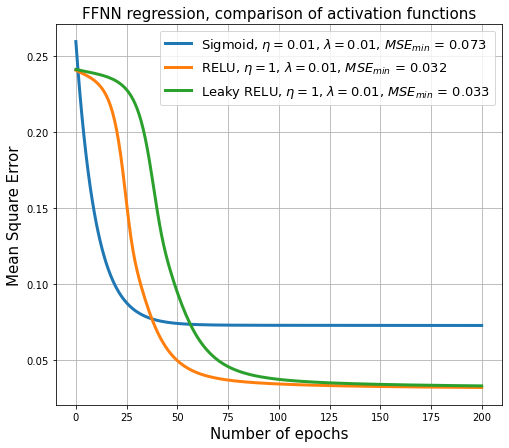

In [36]:
# Runs with different activation functions


## Plotting MSE for each epoch 
fig = plt.figure(figsize = (8, 7))
plt.title('FFNN regression, comparison of activation functions', fontsize = 15)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Mean Square Error', fontsize = 15)

#X, Y, activation function, epochs, learning rate, regularization constant
e1, m1 = FFNN(X_train, z_train, 'Sigmoid', 200, 0.01, 0.01)
e2, m2 = FFNN(X_train, z_train, 'RELU', 200, 1, 0.01)
e3, m3 = FFNN(X_train, z_train, 'Leaky RELU', 200, 1, 0.01)

#diverges suddenly
#e4, m4 = FFNN(X_train, z_train, 'Tanh', 160, 0.5, 0.01)

plt.grid(1); plt.legend(prop={'size': 13}); plt.show()

Appears to converge around MSE = 0.08 with sigmoid (0.036 with relu), which is worse performance than our OLS analysis in proj1. It seems unreasonable for the leaky relu to have such a low MSE immediately.

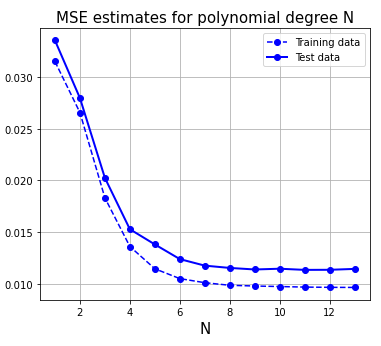
Above: results from ordinary least squares regression in project 1

## Building the network with scikit-learn 

In [37]:
from sklearn.neural_network import MLPClassifier